In [ ]:
# default_exp benchmark.traceability

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# Traceability Benchmark

> This module is dedicated benchmarking

In [ ]:
#export
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import sentencepiece as sp

from abc import ABC, abstractmethod

# ds4se
from ds4se.exp.info import *
from ds4se.desc.stats import *
from ds4se.mgmnt.prep.bpe import *
from ds4se.vis import *

from pathlib import Path

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
class Testbed(ABC):
    def __init__(self, data):
        self.data = data
        super().__init__()
    
    @abstractmethod
    def evaluate(self, inpt):
        pass

In [ ]:
# export
class Procedure(ABC):
    def __init__(self, metrics):
        self.metrics = vectorimetricszor
        super().__init__()
    
    @abstractmethod
    def evaluate(self, inpt):
        pass

In [ ]:
# export
class Benchmark(ABC):
    def __init__(self, testbed, procedure):
        self.testbed = testbed
        self.procedure = procedure
        super().__init__()
    
    @abstractmethod
    def evaluate(self, inpt):
        pass

In [ ]:
path = Path('../benchmarking/traceability/')

## BPE Testbed

In [ ]:
english_bpe = 'english_bpe'
italian_bpe = 'italian_bpe'

In [ ]:
sp_model_from_glob(path/'datasets/english','*/*all*', english_bpe)
sp_model_from_glob(path/'datasets/italian','*/*all*', italian_bpe)

In [ ]:
path/'datasets'

PosixPath('../benchmarking/traceability/datasets')

In [ ]:
def output_bpe_tokenization(path, languages):
    for language in languages:
        req_fns = list((path/'datasets'/language).glob('**/*req]'))
        src_fns = list((path/'datasets'/language).glob('**/*src]'))
        tc_fns = list((path/'datasets'/language).glob('**/*tc]'))

        spm = sp.SentencePieceProcessor()
        spm.Load(str((path/'datasets'/language/f"{language}_bpe.model")))
        
        output = path/'testbeds'/'bpe'/language
        req_docs = tokenize_fns(req_fns, spm, ['txt', 'TXT'], output, 'req')
        src_docs = tokenize_fns(src_fns, spm, ['c', 'h', 'java', 'jsp'], output, 'src')
        tc_docs = tokenize_fns(tc_fns, spm, ['c', 'h', 'java', 'jsp'], output, 'tc')

In [ ]:
languages = ['english', 'italian']
output_bpe_tokenization(path, languages)

# Entropy Benchmark

## Read in the data

In [ ]:
english_systems = {'itrust': ['req', 'src'], 'libest': ['req', 'src', 'tc']}
italian_systems = {'albergate': ['req', 'src'], 'ebt': ['req', 'src', 'tc'], 'etour': ['req', 'src'], 'smos': ['req', 'src']}

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
def benchmark_testbed(gt, ngt, sys, data_type):
    gt = gt.loc[gt['sys'] == sys]
    ngt = ngt.loc[ngt['sys'] == sys]
    gt = gt.loc[gt['to_type'] == data_type]
    ngt = ngt.loc[ngt['to_type'] == data_type]
    
    gt_from = gt['from_doc'].sample(frac = 1).to_list()[:100]
    gt_to = gt['to_doc'].sample(frac = 1).to_list()[:100]
    ngt_from = ngt['from_doc'].sample(frac = 1).to_list()[:100]
    ngt_to = ngt['to_doc'].sample(frac = 1).to_list()[:100]
    
    return gt_from, gt_to, ngt_from, ngt_to

In [ ]:
def benchmark_metrics(from_docs, to_docs):
    from_entropies = get_entropies_from_docs(from_docs)
    to_entropies = get_entropies_from_docs(to_docs)

    shared_probs = [get_shared_probs_from_docs([[docs[0]], [docs[1]]])[0] for docs in zip(from_docs, to_docs)]
    
    return from_entropies, to_entropies, shared_probs

In [ ]:
def benchmark_visualize(gts, ngts, sys, trgt_type):
    visualize_gt_ngt([gts[0], gts[1]], [ngts[0], ngts[1]], sys, trgt_type)
    visualize_events(gts[2], 'b', f'{sys}-{trgt_type}', 'groundtruth')
    visualize_events(ngts[2], 'r', f'{sys}-{trgt_type}', 'non-groundtruth')

In [ ]:
def calc_entropy_benchmark(path, systems, lang):
    gt, ngt = gen_gt_ngt(path/'testbeds', lang)
    for sys in systems:
        print('System:', sys)
        
        sys_docs = []
        for data_type in systems[sys]:
            if data_type != 'req':
                gt_from, gt_to, ngt_from, ngt_to = benchmark_testbed(gt, ngt, sys, data_type)
                gt_from_entropies, gt_to_entropies, gt_shared_probs = benchmark_metrics(gt_from, gt_to)
                ngt_from_entropies, ngt_to_entropies, ngt_shared_probs = benchmark_metrics(ngt_from, ngt_to)
                benchmark_visualize([gt_from_entropies, gt_to_entropies, gt_shared_probs],
                                    [ngt_from_entropies, ngt_to_entropies, ngt_shared_probs],
                                    sys, data_type
                                   )
            
            data_path = path/'testbeds/bpe'/lang/sys/data_type
            sys_docs.append(read_bpe_files(data_path))
            entropies = get_entropies_from_docs(sys_docs[-1])

            print('Data Type:', data_type)
            report_stats(entropies)

            entropy = get_entropy_from_docs(sys_docs[-1])
            print('Total Corpus Entropy:', entropy)
            print()

        entropy = get_entropy_from_docs(flatten(sys_docs))
        print('Total System Entropy:', entropy)
        entropy = shared_entropy_from_docs(sys_docs)
        print('Shared Entropy:', entropy)
        shared_prob, shared_info_content = get_shared_probs_from_docs(sys_docs)
        print('Shared Relative Probability:', shared_prob)
#         print('Shared Information Content:', shared_info_content)
        print()

System: itrust
Data Type: req
Max: 6.655947403853904
Min: 3.6464393446710157
Average: 5.125309432616202
Median: 5.23890125660263
Standard Deviation: 0.7675282320547024
Median Absolute Deviation: 0.949724465856331
95% of the data fall within 4.992640720488694 and 5.25797814474371
Total Corpus Entropy: 8.138886303909846



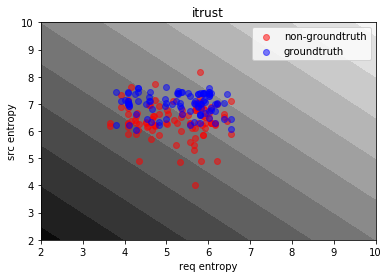

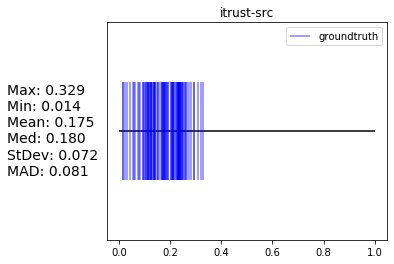

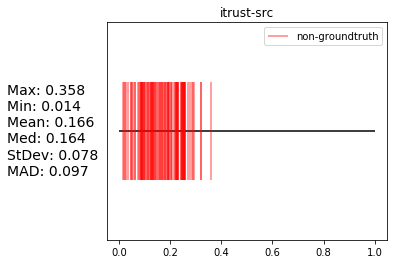

Data Type: src
Max: 7.747087175535515
Min: 4.51364592935837
Average: 6.584188480250173
Median: 6.607110320868633
Standard Deviation: 0.5302214180761683
Median Absolute Deviation: 0.5515873888444468
95% of the data fall within 6.527031493101348 and 6.641345467398998
Total Corpus Entropy: 8.934418803418986

Total System Entropy: 9.009082050954651
Shared Entropy: 6.763812739263795
Shared Relative Probability: 0.47147080887868964

System: libest
Data Type: req
Max: 8.133644403908326
Min: 4.694019357121934
Average: 6.543663643429754
Median: 6.5960839256764
Standard Deviation: 0.7998515650224864
Median Absolute Deviation: 0.8070430386925501
95% of the data fall within 6.3209835459644115 and 6.766343740895097
Total Corpus Entropy: 9.183085440385813



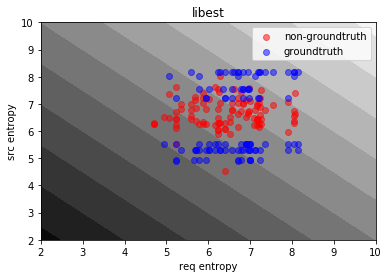

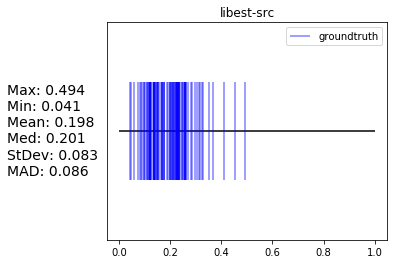

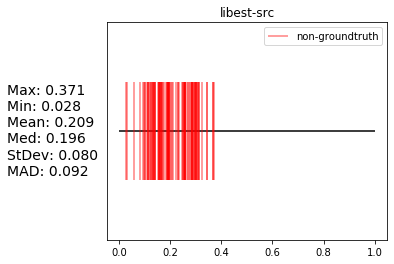

Data Type: src
Max: 8.16742303287423
Min: 4.004576449759753
Average: 6.177486953628029
Median: 5.523275682146648
Standard Deviation: 1.5603686286639487
Median Absolute Deviation: 2.251623481936811
95% of the data fall within 4.978081450336224 and 7.376892456919834
Total Corpus Entropy: 8.227602603165863



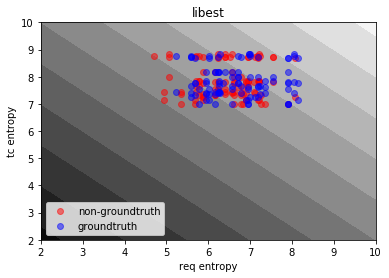

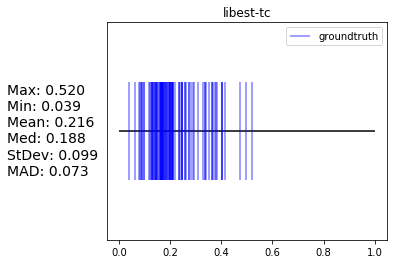

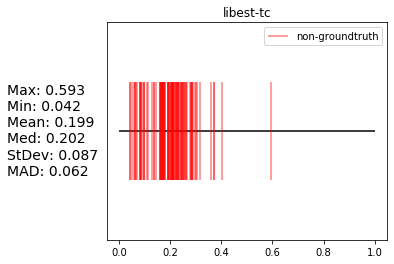

Data Type: tc
Max: 8.84281643986258
Min: 6.981127448895606
Average: 7.833269648196844
Median: 7.643609989333774
Standard Deviation: 0.5961050558091697
Median Absolute Deviation: 0.49366977593502526
95% of the data fall within 7.561925879993082 and 8.104613416400605
Total Corpus Entropy: 8.642622470130963

Total System Entropy: 8.990228755577743
Shared Entropy: 7.192527544375066
Shared Relative Probability: 0.6400115702217357



In [ ]:
calc_entropy_benchmark(path, english_systems, 'english')

System: albergate
Data Type: req
Max: 7.451061154959708
Min: 6.7760271692033065
Average: 7.114662232676978
Median: 7.1361285831247265
Standard Deviation: 0.1802867011866648
Median Absolute Deviation: 0.19215087521795424
95% of the data fall within 7.021967364311235 and 7.207357101042722
Total Corpus Entropy: 8.333064635075106



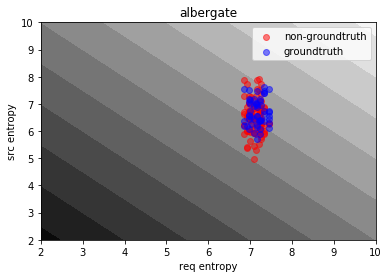

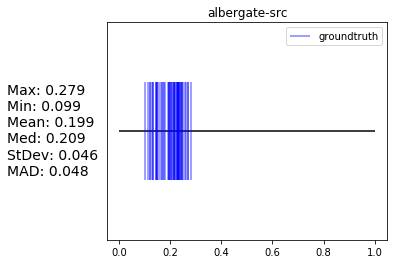

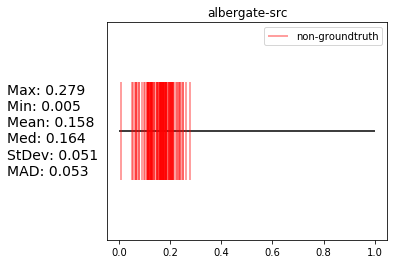

Data Type: src
Max: 7.632003142360007
Min: 5.694455777930451
Average: 6.698395952158591
Median: 6.585514345171939
Standard Deviation: 0.47533702601616074
Median Absolute Deviation: 0.5563741051053886
95% of the data fall within 6.569894354034409 and 6.826897550282773
Total Corpus Entropy: 8.026350097173456

Total System Entropy: 8.284551907349751
Shared Entropy: 5.704935783592468
Shared Relative Probability: 0.33135155648064085

System: ebt
Data Type: req
Max: 4.85798099512757
Min: 3.169925001442312
Average: 4.036522483018428
Median: 4.037401197654112
Standard Deviation: 0.4423825943264807
Median Absolute Deviation: 0.49957908952600216
95% of the data fall within 3.896889307383322 and 4.176155658653533
Total Corpus Entropy: 6.787949596598941



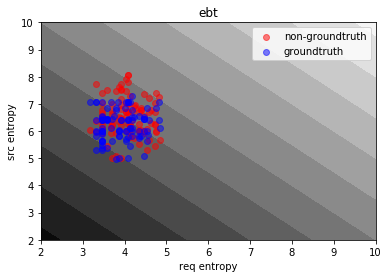

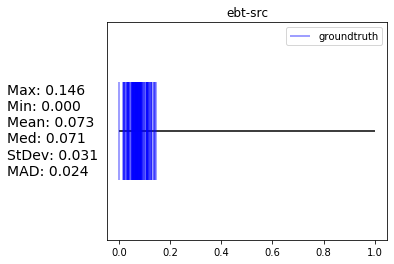

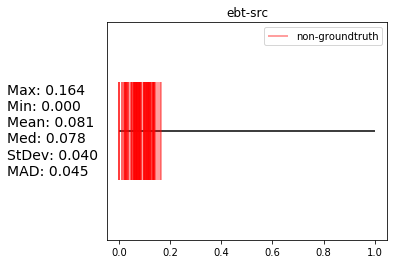

Data Type: src
Max: 7.297368573550913
Min: 4.784576473149471
Average: 5.963495662337905
Median: 5.903977747837278
Standard Deviation: 0.633890544451061
Median Absolute Deviation: 0.7640379035089372
95% of the data fall within 5.783345963113105 and 6.143645361562706
Total Corpus Entropy: 8.433164216462012



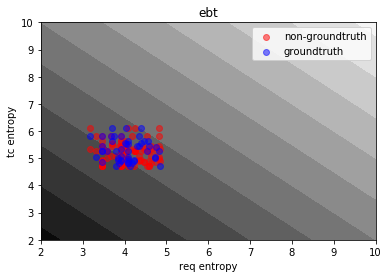

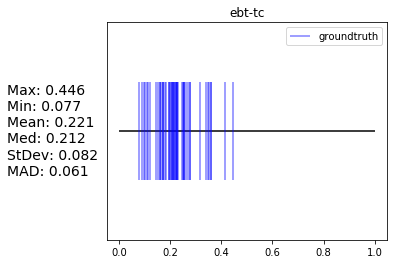

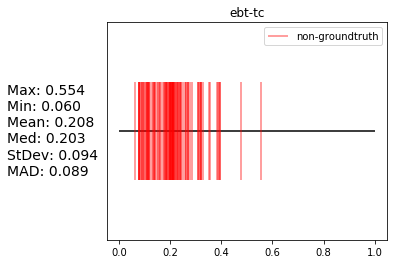

Data Type: tc
Max: 6.097097085934415
Min: 4.704511459715549
Average: 5.247301653814626
Median: 5.281405982501043
Standard Deviation: 0.36921703418357255
Median Absolute Deviation: 0.409448742188667
95% of the data fall within 5.094896352658618 and 5.399706954970633
Total Corpus Entropy: 7.081408121899548

Total System Entropy: 8.65824233434985
Shared Entropy: 5.006590016354143
Shared Relative Probability: 0.2338971064883024

System: etour
Data Type: req
Max: 6.237393834397654
Min: 5.29192090403933
Average: 5.852879032919363
Median: 5.845473100698095
Standard Deviation: 0.1917565510946936
Median Absolute Deviation: 0.1803895702893011
95% of the data fall within 5.802459218071262 and 5.903298847767464
Total Corpus Entropy: 7.10566459632011



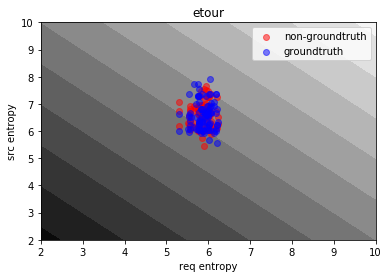

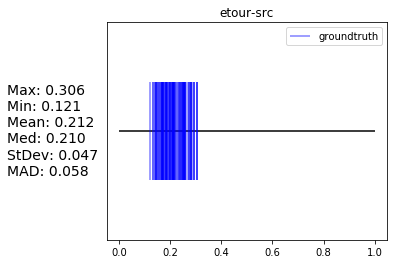

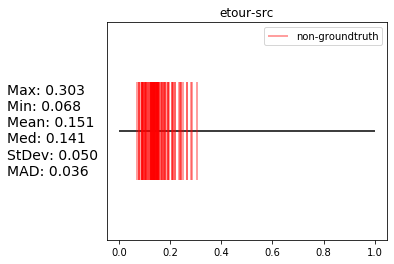

Data Type: src
Max: 8.048968980820781
Min: 5.539696852908118
Average: 6.562921919889305
Median: 6.565193494077665
Standard Deviation: 0.5410162090028992
Median Absolute Deviation: 0.5387698222061198
95% of the data fall within 6.463421809399394 and 6.662422030379217
Total Corpus Entropy: 8.746300951068172

Total System Entropy: 8.821970266170093
Shared Entropy: 5.822212387865012
Shared Relative Probability: 0.333506370324796

System: smos
Data Type: req
Max: 6.620285755044159
Min: 5.400701696091559
Average: 6.117630402688541
Median: 6.14042834992966
Standard Deviation: 0.30288713322086686
Median Absolute Deviation: 0.2983853257033212
95% of the data fall within 6.043750425878531 and 6.191510379498552
Total Corpus Entropy: 7.395107792428339



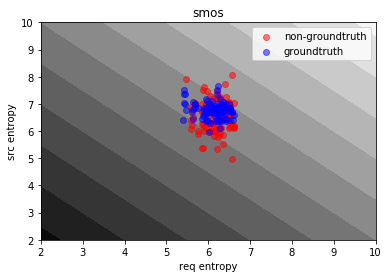

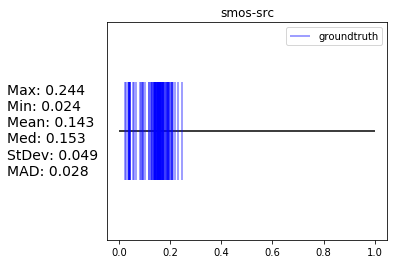

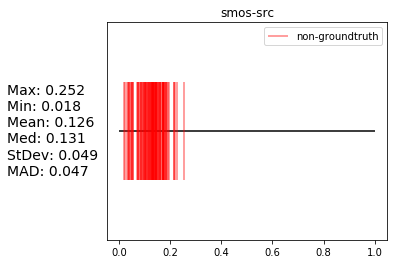

Data Type: src
Max: 7.868448246363016
Min: 5.351552244391098
Average: 6.646037374067181
Median: 6.700747575555027
Standard Deviation: 0.4604239797792222
Median Absolute Deviation: 0.35472181488677074
95% of the data fall within 6.554679267511279 and 6.737395480623084
Total Corpus Entropy: 8.357381483417843

Total System Entropy: 8.595914118672756
Shared Entropy: 5.660800120573564
Shared Relative Probability: 0.3023618380424987



In [ ]:
calc_entropy_benchmark(path, italian_systems, 'italian')

In [ ]:
def calc_entropy_benchmark_old(path, systems, lang, n_samps = 256):
    gt, ngt = gen_gt_ngt(path/'testbeds', lang)
    for sys in systems:
        gt_sys = gt.loc[gt['sys'] == sys]
        ngt_sys = ngt.loc[ngt['sys'] == sys]
        
        gt_from = gt_sys['from_doc'].sample(frac = 1).to_list()[:n_samps]
        gt_to = gt_sys['to_doc'].sample(frac = 1).to_list()[:n_samps]
        ngt_from = ngt_sys['from_doc'].sample(frac = 1).to_list()[:len(gt_from)]
        ngt_to = ngt_sys['to_doc'].sample(frac = 1).to_list()[:len(gt_to)]
        
        gt_from_entropies, gt_to_entropies, gt_shared_probs = benchmark_metrics(gt_from, gt_to)
        ngt_from_entropies, ngt_to_entropies, ngt_shared_probs = benchmark_metrics(ngt_from, ngt_to)
        
        print('System:', sys)
        visualize_gt_ngt([gt_from_entropies, gt_to_entropies], [ngt_from_entropies, ngt_to_entropies], sys, 'Source Code')
        visualize_events(gt_shared_probs, 'b', sys, 'groundtruth')
        visualize_events(ngt_shared_probs, 'r', sys, 'non-groundtruth')
        
        sys_docs = []
        for data_type in systems[sys]:
            data_path = path/'testbeds/bpe'/lang/sys/data_type
            sys_docs.append(read_bpe_files(data_path))
            entropies = get_entropies_from_docs(sys_docs[-1])

            print('Data Type:', data_type)
            report_stats(entropies)

            entropy = get_entropy_from_docs(sys_docs[-1])
            print('Total Corpus Entropy:', entropy)
            print()

        entropy = get_entropy_from_docs(flatten(sys_docs))
        print('Total System Entropy:', entropy)
        entropy = shared_entropy_from_docs(sys_docs)
        print('Shared Entropy:', entropy)
        shared_prob, shared_info_content = get_shared_probs_from_docs(sys_docs)
        print('Shared Relative Probability:', shared_prob)
#         print('Shared Information Content:', shared_info_content)
        print()

System: itrust


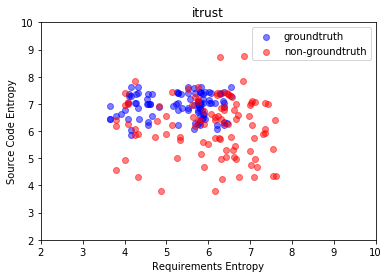

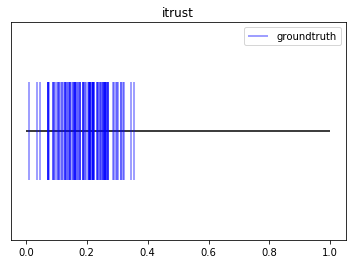

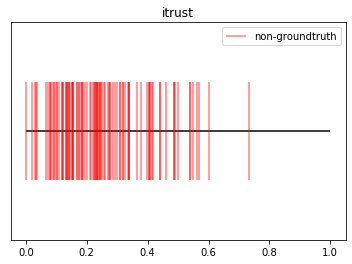

Data Type: req
Max: 6.655947403853904
Min: 3.6464393446710157
Average: 5.125309432616202
Median: 5.23890125660263
Standard Deviation: 0.7675282320547024
Median Absolute Deviation: 0.949724465856331
95% of the data fall within 4.992640720488694 and 5.25797814474371
Total Corpus Entropy: 8.138886303909846

Data Type: src
Max: 7.747087175535515
Min: 4.51364592935837
Average: 6.584188480250173
Median: 6.607110320868633
Standard Deviation: 0.5302214180761683
Median Absolute Deviation: 0.5515873888444468
95% of the data fall within 6.527031493101348 and 6.641345467398998
Total Corpus Entropy: 8.934418803418986

Total System Entropy: 9.009082050954651
Shared Entropy: 6.763812739263795
Shared Relative Probability: 0.47147080887868964

System: libest


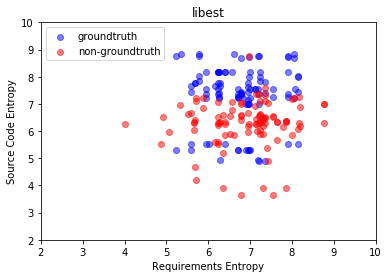

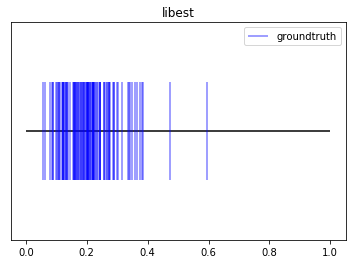

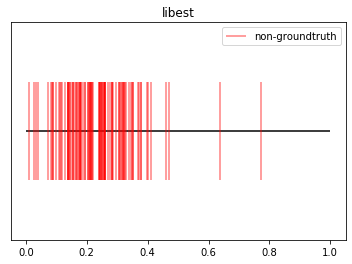

Data Type: req
Max: 8.133644403908326
Min: 4.694019357121934
Average: 6.543663643429754
Median: 6.5960839256764
Standard Deviation: 0.7998515650224864
Median Absolute Deviation: 0.8070430386925501
95% of the data fall within 6.3209835459644115 and 6.766343740895097
Total Corpus Entropy: 9.183085440385813

Data Type: src
Max: 8.16742303287423
Min: 4.004576449759753
Average: 6.177486953628029
Median: 5.523275682146648
Standard Deviation: 1.5603686286639487
Median Absolute Deviation: 2.251623481936811
95% of the data fall within 4.978081450336224 and 7.376892456919834
Total Corpus Entropy: 8.227602603165863

Data Type: tc
Max: 8.84281643986258
Min: 6.981127448895606
Average: 7.833269648196844
Median: 7.643609989333774
Standard Deviation: 0.5961050558091697
Median Absolute Deviation: 0.49366977593502526
95% of the data fall within 7.561925879993082 and 8.104613416400605
Total Corpus Entropy: 8.642622470130963

Total System Entropy: 8.990228755577743


KeyboardInterrupt: 

In [ ]:
calc_entropy_benchmark(path, english_systems, 'english', n_samps = 100)

System: albergate


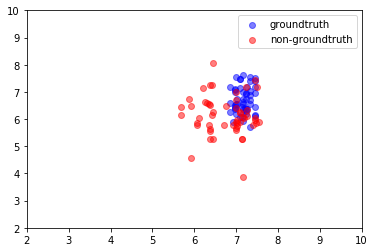

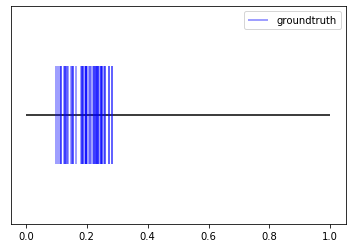

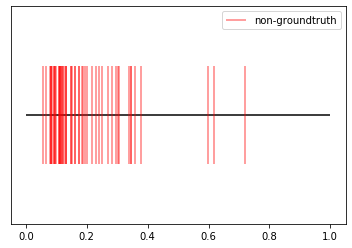

Data Type: req
Max: 7.451061154959707
Min: 6.7760271692033065
Average: 7.114662232676978
Median: 7.136128583124725
Standard Deviation: 0.18028670118666468
Median Absolute Deviation: 0.19215087521795687
95% of the data fall within 7.021967364311235 and 7.207357101042722
Total Corpus Entropy: 8.333064635075104

Data Type: src
Max: 7.632003142360006
Min: 5.694455777930451
Average: 6.698395952158591
Median: 6.585514345171939
Standard Deviation: 0.47533702601616074
Median Absolute Deviation: 0.5563741051053886
95% of the data fall within 6.569894354034409 and 6.826897550282773
Total Corpus Entropy: 8.02635009717346

Total System Entropy: 8.284551907349751
Shared Entropy: 5.704935783592468
Shared Relative Probability: 0.33135155648064085

System: ebt


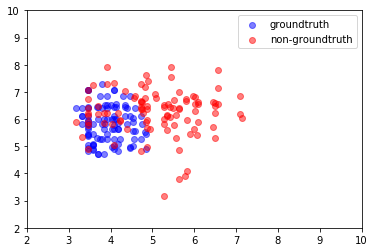

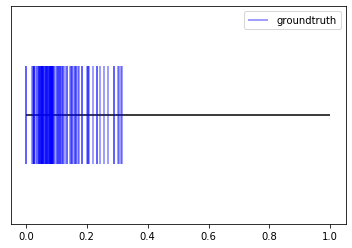

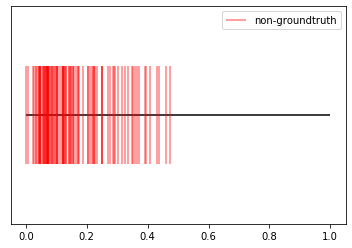

Data Type: req
Max: 4.85798099512757
Min: 3.169925001442312
Average: 4.036522483018428
Median: 4.037401197654112
Standard Deviation: 0.44238259432648075
Median Absolute Deviation: 0.49957908952600216
95% of the data fall within 3.896889307383322 and 4.176155658653533
Total Corpus Entropy: 6.78794959659894

Data Type: src
Max: 7.297368573550913
Min: 4.784576473149472
Average: 5.963495662337905
Median: 5.903977747837278
Standard Deviation: 0.633890544451061
Median Absolute Deviation: 0.7640379035089379
95% of the data fall within 5.783345963113105 and 6.143645361562706
Total Corpus Entropy: 8.433164216462012

Data Type: tc
Max: 6.097097085934414
Min: 4.704511459715548
Average: 5.247301653814626
Median: 5.281405982501043
Standard Deviation: 0.3692170341835723
Median Absolute Deviation: 0.4094487421886657
95% of the data fall within 5.094896352658618 and 5.399706954970633
Total Corpus Entropy: 7.081408121899548

Total System Entropy: 8.65824233434985
Shared Entropy: 5.006590016354143
Share

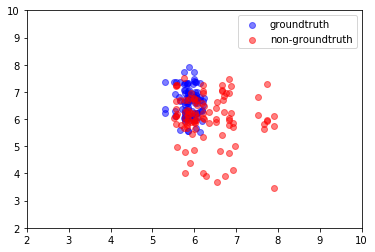

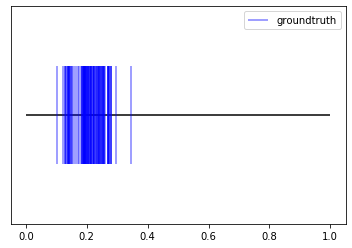

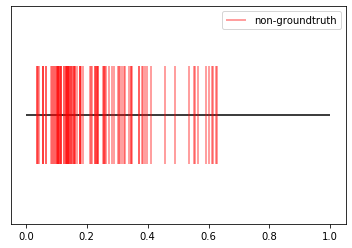

Data Type: req
Max: 6.237393834397654
Min: 5.29192090403933
Average: 5.852879032919364
Median: 5.845473100698095
Standard Deviation: 0.19175655109469367
Median Absolute Deviation: 0.18038957028930175
95% of the data fall within 5.802459218071263 and 5.903298847767465
Total Corpus Entropy: 7.10566459632011

Data Type: src
Max: 8.048968980820781
Min: 5.539696852908118
Average: 6.562921919889305
Median: 6.565193494077665
Standard Deviation: 0.541016209002899
Median Absolute Deviation: 0.5387698222061198
95% of the data fall within 6.463421809399394 and 6.662422030379217
Total Corpus Entropy: 8.74630095106817

Total System Entropy: 8.821970266170094
Shared Entropy: 5.822212387865012
Shared Relative Probability: 0.333506370324796

System: smos


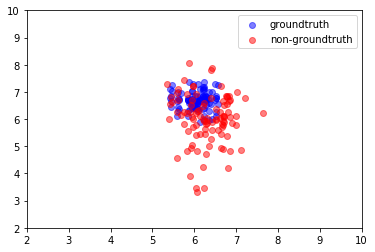

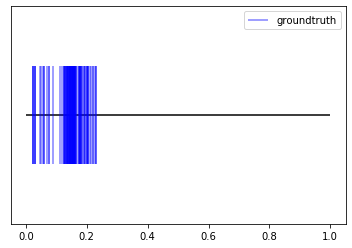

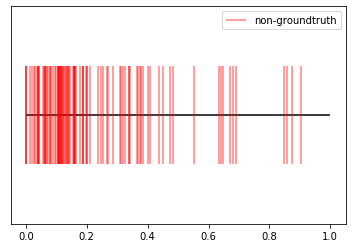

Data Type: req
Max: 6.620285755044159
Min: 5.400701696091559
Average: 6.117630402688541
Median: 6.14042834992966
Standard Deviation: 0.30288713322086697
Median Absolute Deviation: 0.2983853257033212
95% of the data fall within 6.043750425878531 and 6.191510379498552
Total Corpus Entropy: 7.39510779242834

Data Type: src
Max: 7.868448246363015
Min: 5.351552244391098
Average: 6.646037374067181
Median: 6.700747575555027
Standard Deviation: 0.46042397977922234
Median Absolute Deviation: 0.354721814886772
95% of the data fall within 6.554679267511279 and 6.737395480623084
Total Corpus Entropy: 8.357381483417843

Total System Entropy: 8.595914118672756
Shared Entropy: 5.660800120573564
Shared Relative Probability: 0.3023618380424987



In [ ]:
calc_entropy_benchmark(path, italian_systems, 'italian', n_samps = 100)

# SCRATCH WORK

In [ ]:
gt_english, ngt_english = gen_gt_ngt(path/'testbeds', 'english')

In [ ]:
gt_english.head()

,sys,from_type,to_type,from_file,to_file,from_doc,to_doc
0,itrust,req,src,UC10E1.bpe,getUser.bpe,"[▁The, ▁health, ▁care, ▁professional, ▁types, ...","[▁<%@, ▁page, ▁import, ="", java, ., net, ., UR..."
1,itrust,req,src,UC10E1.bpe,GetUserNameAction.bpe,"[▁The, ▁health, ▁care, ▁professional, ▁types, ...","[▁p, ackage, ▁edu, ., nc, su, ., cs, c, ., itr..."
2,itrust,req,src,UC10E1.bpe,AuthDAO.bpe,"[▁The, ▁health, ▁care, ▁professional, ▁types, ...","[▁p, ackage, ▁edu, ., nc, su, ., cs, c, ., itr..."
3,itrust,req,src,UC10E2.bpe,getUser.bpe,"[▁The, ▁patient, ▁cho, sen, ▁is, ▁not, ▁the, ▁...","[▁<%@, ▁page, ▁import, ="", java, ., net, ., UR..."
4,itrust,req,src,UC10E2.bpe,GetUserNameAction.bpe,"[▁The, ▁patient, ▁cho, sen, ▁is, ▁not, ▁the, ▁...","[▁p, ackage, ▁edu, ., nc, su, ., cs, c, ., itr..."


In [ ]:
ngt_english.head()

,sys,from_type,to_type,from_file,to_file,from_doc,to_doc
0,libest,req,src,RQ7.bpe,est_locl.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁, LIB, EST, _, TEST, _, API, ▁void, ▁est, _,..."
1,libest,req,src,RQ7.bpe,est.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁/**, ▁@, file, ▁*/, ▁/*, --, ---------------..."
2,libest,req,src,RQ7.bpe,est_proxy.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁/*, ▁*, ▁S, ince, ▁we, ▁, hij, ack, ▁the, ▁O..."
3,libest,req,src,RQ7.bpe,est_client_proxy.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁t, cw, _, err, _, t, ▁t, cw, _, connect, (, ..."
4,libest,req,src,RQ7.bpe,est_ossl_util.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁int, ▁ossl, _, verify, _, cb, (, int, ▁ok, ,..."


In [ ]:
sample_gt_from_en = gt_english['from_doc'].sample(frac = 0.1).to_list()
sample_gt_to_en = gt_english['to_doc'].sample(frac = 0.1).to_list()

In [ ]:
sample_ngt_from_en = ngt_english['from_doc'].sample(frac = 0.1).to_list()
sample_ngt_to_en = ngt_english['to_doc'].sample(frac = 0.1).to_list()

In [ ]:
gt_from_entropies = get_entropies_from_docs(sample_gt_from_en)
gt_to_entropies = get_entropies_from_docs(sample_gt_to_en)

In [ ]:
ngt_from_entropies = get_entropies_from_docs(sample_ngt_from_en)
ngt_to_entropies = get_entropies_from_docs(sample_ngt_to_en)

In [ ]:
gt_shared_probs = [get_shared_probs_from_docs(docs)[0] for docs in zip(sample_gt_from_en, sample_gt_to_en)]
ngt_shared_probs = [get_shared_probs_from_docs(docs)[0] for docs in zip(sample_ngt_from_en, sample_ngt_to_en)]

In [ ]:
import matplotlib.pyplot as plt

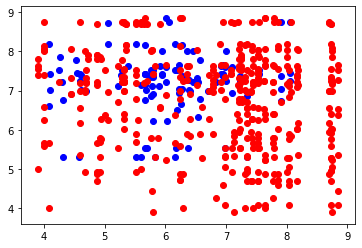

In [ ]:
plt.scatter(gt_from_entropies, gt_to_entropies, c='b')
plt.scatter(ngt_from_entropies, ngt_to_entropies, c='r')
plt.show()

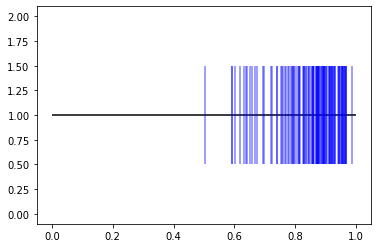

In [ ]:
plt.hlines(1,0,1)  # Draw a horizontal line
plt.eventplot(gt_shared_probs, orientation='horizontal', colors='b', alpha = 0.5)
# plt.margins(x=5, y=5)
plt.show()

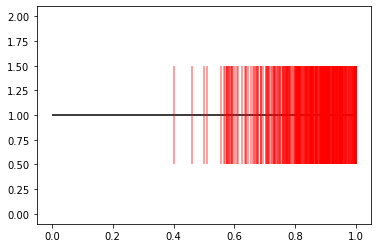

In [ ]:
plt.hlines(1,0,1)  # Draw a horizontal line
plt.eventplot(ngt_shared_probs, orientation='horizontal', colors='r', alpha = 0.5)
plt.show()

In [ ]:

for language in languages:
    req_fns = list((path/'datasets'/language).glob('**/*req]'))
    src_fns = list((path/'datasets'/language).glob('**/*src]'))
    tst_fns = list((path/'datasets'/language).glob('**/*tc]'))
    
    spm = sp.SentencePieceProcessor()
    spm.Load(str((path/'datasets'/language/f"{model_name}_bpe.model"))\
    
    all_fns = flatten(req_fns + src_fns + tst_fns)
    all_docs = tokenize_fns(all_fns, spm)

In [ ]:
req_fns = list((path/'datasets/english').glob('**/*req]'))
src_fns = list((path/'datasets/english').glob('**/*src]'))
tst_fns = list((path/'datasets/english').glob('**/*tc]'))
req_fns[:5], src_fns[:5], tst_fns[:5]

([PosixPath('../benchmarking/traceability/datasets/english/libest/[libest-raw-req]'),
  PosixPath('../benchmarking/traceability/datasets/english/itrust/[itrust-raw-req]')],
 [PosixPath('../benchmarking/traceability/datasets/english/libest/[libest-raw-src]'),
  PosixPath('../benchmarking/traceability/datasets/english/itrust/[itrust-raw-src]')],
 [PosixPath('../benchmarking/traceability/datasets/english/libest/[libest-raw-tc]')])

In [ ]:
all_fns = flatten(req_fns + src_fns + tst_fns)
all_docs = tokenize_fns(all_fns, spm)

In [ ]:
req_docs = 

In [ ]:
src_fns[0].parent.name

'libest'

In [ ]:
list(path.glob('datasets/italian/*/*'))

[PosixPath('../benchmarking/traceability/datasets/italian/smos/[smos-raw-src]'),
 PosixPath('../benchmarking/traceability/datasets/italian/smos/[smos-raw-req]'),
 PosixPath('../benchmarking/traceability/datasets/italian/smos/[smos-all].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/albergate/[albergate-all].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/albergate/[albergate-raw-src]'),
 PosixPath('../benchmarking/traceability/datasets/italian/albergate/[albergate-raw-req]'),
 PosixPath('../benchmarking/traceability/datasets/italian/ebt/[ebt-all].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/ebt/[ebt-raw-src]'),
 PosixPath('../benchmarking/traceability/datasets/italian/ebt/[ebt-raw-tc].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/ebt/[ebt-raw-req].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/etour/[etour-raw-src]'),
 PosixPath('../benchmarking/traceability/datasets/italian/etour/[etour-raw-req

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_mgmnt.prep.i.ipynb.
Converted 01_exp.i.ipynb.
Converted 02_mgmnt.db.mongo.ipynb.
Converted 03_repr.i.ipynb.
Converted 04_mining.ir.model.ipynb.
Converted 05_mining.ir.i.ipynb.
Converted 06_benchmark.traceability.ipynb.
Converted 07_repr.roberta.train.ipynb.
Converted 08_exp.info.ipynb.
Converted 09_desc.stats.ipynb.
Converted 10_vis.ipynb.
Converted 11_mgmnt.prep.nltk.ipynb.
Converted 12_repr.roberta.eval.ipynb.
Converted 14_mgmnt.prep.bpe.ipynb.
Converted 15_desc.metrics.se.ipynb.
Converted 16_repr.word2vec.train.ipynb.
Converted 17_repr.doc2vec.train.ipynb.
Converted 18_repr.doc2vec.eval.ipynb.
Converted 19_repr.word2vec.eval.ipynb.
Converted 20_benchmark.codegen.ipynb.
Converted 21_inf.i.ipynb.
Converted 22_inf.bayesian.ipynb.
Converted 23_inf.causal.ipynb.
Converted aa_blog.example.ipynb.
Converted ab_templates.example.ipynb.
Converted ac_emp.eval.pp1.rq1.ipynb.
Converted ad_emp.eval.pp1.rq2.ipynb.
Converted ae_emp.eval.pp1.rq3.ipynb.
Converted af_emp.eval.pp1.rq4.ipyn